## Auto-Encoder Based on DC-GAN encoder and decoder 

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
from PIL import Image

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_reconstructions(x, x_hat):
    imsize = 32
    n_rows = 10
    x = np.reshape(x[:50], [5, 10, imsize, imsize])
    x_hat = np.reshape(x_hat[:50], [5, 10, imsize, imsize])
    canvas = np.zeros([imsize * 10, imsize * 10])
    for i in range(5):
        canvas[2*i*imsize:(2*i+1)*imsize, :] = np.transpose(x[i], [0, 2, 1]).reshape([imsize * 10, imsize]).T
        canvas[(2*i+1)*imsize:(2*i+2)*imsize, :] = np.transpose(x_hat[i], [0, 2, 1]).reshape([imsize * 10, imsize]).T
    plt.imshow(canvas, cmap='Greys_r')
    plt.show()

In [3]:
def render_images(np_x):
    np_x = np_x.reshape((10,10,32,32))
    np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
    np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
    x_img = np.squeeze(np_x)
    plt.imshow(x_img, cmap='Greys_r')
    plt.show()

In [4]:
from skimage.transform import resize
def resize_images(X):
    X_resized = np.zeros([X.shape[0], 32, 32, X.shape[-1]])
    for i, x in enumerate(X):
        X_resized[i] = resize(x, (32, 32))
    return X_resized

In [5]:
def batch_generator(X, batch_size=100):
    n_samples = X.shape[0]
    n_batches = int(np.ceil(n_samples/batch_size))
    while True:
        np.random.shuffle(X)
        for b in range(n_batches):
            batch = X[b*batch_size:(b+1)*batch_size]
            yield batch

In [6]:
# DC-GAN encoder and decoder
def encoder(x, z_dim=32, ndf=64, training=True, reuse=False):
    imwidth, imheight, nc = x.get_shape()[1:]
    assert imwidth == imheight and imwidth % 16 == 0
    with tf.variable_scope('encoder', reuse=reuse):
        z = tf.layers.conv2d(x, ndf, 4, 2, padding='same', activation=None, use_bias=False)
        z = tf.nn.leaky_relu(z, 0.2)
        cur_size, nchannels = imwidth // 2, ndf
        while cur_size > 4:
            nchannels *= 2
            z = tf.layers.conv2d(z, nchannels, 4, 2, padding='same', activation=None, use_bias=False)
            z = tf.layers.batch_normalization(z, epsilon=1e-5, momentum=0.9, training=training)
            z = tf.nn.leaky_relu(z, 0.2)
            cur_size = cur_size // 2
        z = tf.layers.conv2d(z, z_dim, 4, 1, padding='valid', activation=None, use_bias=False)
    return z

def decoder(z, imsize=32, nc=1, ngf=64, training=True, reuse=False):
    cur_size, nchannels = 4, ngf
    while cur_size != imsize:
        cur_size *= 2
        nchannels *= 2
    cur_size = 4
    with tf.variable_scope('decoder', reuse=reuse):
        z = tf.layers.conv2d_transpose(z, nchannels, 4, 1, padding='valid', activation=None, use_bias=False)
        z = tf.layers.batch_normalization(z, epsilon=1e-5, momentum=0.9, training=training)
        z = tf.nn.relu(z)
        while cur_size < imsize // 2:
            nchannels = nchannels // 2
            z = tf.layers.conv2d_transpose(z, nchannels, 4, 2, padding='same', activation=None, use_bias=False)
            z = tf.layers.batch_normalization(z, epsilon=1e-5, momentum=0.9, training=training)
            z = tf.nn.relu(z)
            cur_size *= 2
        z = tf.layers.conv2d_transpose(z, nc, 4, 2, padding='same', activation=None, use_bias=False)
        x_hat = tf.nn.sigmoid(z)
    return x_hat

In [7]:
train_data_file = 'train_X.npy'
test_data_file = 'test_X.npy'
if not (os.path.exists(train_data_file) and os.path.exists(test_data_file)):
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=False)
    train_X = resize_images(mnist.train.images)
    test_X = resize_images(mnist.test.images)
    np.save(train_data_file, train_X)
    np.save(test_data_file, test_X)
train_X = np.load(train_data_file)
test_X = np.load(test_data_file)

In [8]:
batch_size = 100
nb_steps = 50000

In [9]:
x = tf.placeholder(tf.float32, [None, 32, 32, 1])
z = encoder(x)
x_hat = decoder(z)
ae_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1, 2, 3]))

In [10]:
x_test = tf.placeholder(tf.float32, [None, 32, 32, 1])
x_recons = decoder(encoder(x_test, reuse=True, training=False), reuse=True, training=False)

In [11]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_ae_op = tf.train.RMSPropOptimizer(0.0005).minimize(ae_loss, var_list=tf.trainable_variables('decoder') + tf.trainable_variables('encoder'))
init_op = tf.global_variables_initializer()

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [13]:
train_batches = batch_generator(train_X, batch_size)
test_batches = batch_generator(test_X, batch_size=50)

Step: 1000 in 21.22s :: Loss: 3.677
Step: 2000 in 20.51s :: Loss: 2.538
Step: 3000 in 20.90s :: Loss: 2.050
Step: 4000 in 21.01s :: Loss: 1.743
Step: 5000 in 20.85s :: Loss: 1.804


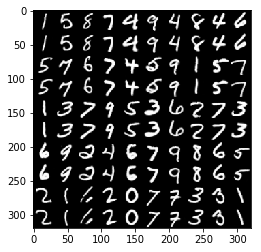

Step: 6000 in 20.85s :: Loss: 1.841
Step: 7000 in 20.92s :: Loss: 1.821
Step: 8000 in 20.96s :: Loss: 1.454
Step: 9000 in 20.97s :: Loss: 1.413
Step: 10000 in 20.95s :: Loss: 1.327


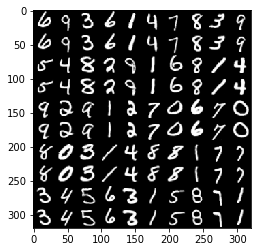

Step: 11000 in 20.87s :: Loss: 1.249
Step: 12000 in 20.88s :: Loss: 1.432
Step: 13000 in 21.09s :: Loss: 1.164
Step: 14000 in 21.04s :: Loss: 1.081
Step: 15000 in 20.97s :: Loss: 1.147


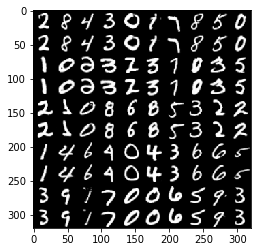

Step: 16000 in 21.12s :: Loss: 0.971
Step: 17000 in 20.92s :: Loss: 0.954
Step: 18000 in 21.11s :: Loss: 0.958
Step: 19000 in 21.22s :: Loss: 1.074
Step: 20000 in 21.07s :: Loss: 1.093


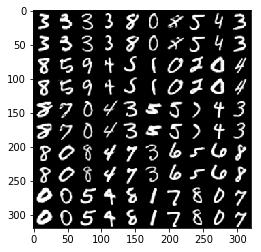

Step: 21000 in 21.46s :: Loss: 0.927
Step: 22000 in 20.81s :: Loss: 0.885
Step: 23000 in 21.10s :: Loss: 0.940
Step: 24000 in 20.96s :: Loss: 0.987
Step: 25000 in 21.23s :: Loss: 0.888


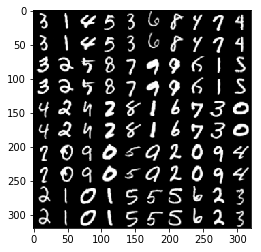

Step: 26000 in 21.13s :: Loss: 0.957
Step: 27000 in 20.92s :: Loss: 0.843
Step: 28000 in 20.77s :: Loss: 0.896
Step: 29000 in 20.96s :: Loss: 0.974
Step: 30000 in 21.03s :: Loss: 0.917


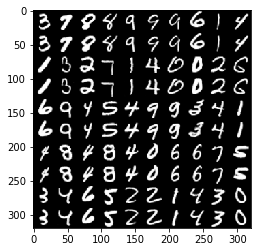

Step: 31000 in 21.25s :: Loss: 0.731
Step: 32000 in 21.03s :: Loss: 0.967
Step: 33000 in 20.78s :: Loss: 0.725
Step: 34000 in 21.13s :: Loss: 0.670
Step: 35000 in 21.03s :: Loss: 0.684


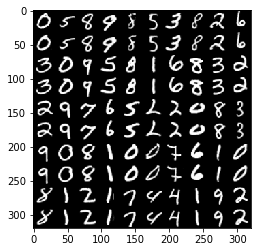

Step: 36000 in 21.05s :: Loss: 0.734
Step: 37000 in 21.01s :: Loss: 0.678
Step: 38000 in 21.03s :: Loss: 0.672
Step: 39000 in 20.86s :: Loss: 0.747
Step: 40000 in 17.30s :: Loss: 0.789


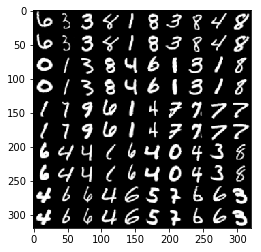

Step: 41000 in 15.93s :: Loss: 0.642
Step: 42000 in 15.86s :: Loss: 0.917
Step: 43000 in 15.83s :: Loss: 0.608
Step: 44000 in 15.64s :: Loss: 0.793
Step: 45000 in 15.90s :: Loss: 0.885


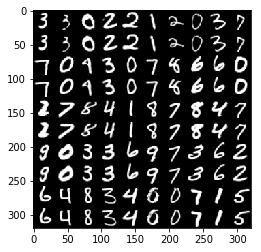

Step: 46000 in 15.96s :: Loss: 0.750
Step: 47000 in 15.83s :: Loss: 0.641
Step: 48000 in 15.82s :: Loss: 0.601
Step: 49000 in 15.88s :: Loss: 0.727
Step: 50000 in 15.62s :: Loss: 0.649


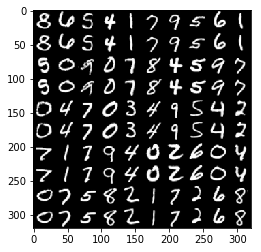

In [14]:
sess.run(init_op)
start_time = time.time()
for i in range(1, nb_steps+1):
    x_np = next(train_batches)
    _, ae_loss_np = sess.run([train_ae_op, ae_loss], feed_dict={x: x_np})
    if i % 1000 == 0:
        end_time = time.time()
        print('Step: {:d} in {:.2f}s :: Loss: {:.3f}'.format(i, end_time - start_time, ae_loss_np))
        start_time = end_time
    if i % 5000 == 0:
        x_test_np = next(test_batches)
        x_recons_np = sess.run(x_recons, feed_dict={x_test: x_test_np})
        plot_reconstructions(x_test_np, x_recons_np)